### Introduction

Not much here except very simple features that build on the fact we know the future...

In all time series competition where you're allowed to use future events the best features are time to next session for a given visitor.

This competition is no exception.

I left part of the features I already tested and don't seem to generalize... but what can we really trust here ?


In [2]:
import os
print(os.listdir("F:/kaggle"))

['.ipynb_checkpoints', 'feature_extract.py', 'fork-of-eda-on-basic-data-and-lgb-in-progress.ipynb', 'GoogleAnalytics_week_3.ipynb', 'latest_update', 'latest_update.zip', 'test_v2.csv', 'test_v2.csv.zip', 'train-1.csv', 'train_v2.csv', 'train_v2.csv.zip']


In [3]:
# import sys,platform
# platform.architecture()

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import gc
import time
from pandas.core.common import SettingWithCopyWarning
import warnings
import lightgbm as lgb
from sklearn.model_selection import GroupKFold
from pandas.io.json import json_normalize
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import TimeSeriesSplit, KFold
from sklearn.metrics import mean_squared_error
# I don't like SettingWithCopyWarnings ...
warnings.simplefilter('error', SettingWithCopyWarning)
gc.enable()
%matplotlib inline

In [5]:
import json

### Get the extracted data

In [6]:
def load_df(csv_path, nrows=None):
    USE_COLUMNS = [
        'channelGrouping', 'date', 'device', 'fullVisitorId', 'geoNetwork',
        'socialEngagementType', 'totals', 'trafficSource', 'visitId',
        'visitNumber', 'visitStartTime', 'customDimensions'
        #,'hits'
    ]
    JSON_COLUMNS = ['device','geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column:json.loads for column in JSON_COLUMNS}, 
                     dtype={'date': str, 'fullVisitorId': str, 'sessionId':str}, # Important!!
                     nrows=nrows, usecols=USE_COLUMNS)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

In [11]:
%%time
train = load_df("F:/kaggle/train_v2.csv")

Loaded train_v2.csv. Shape: (1708337, 59)
Wall time: 3min 51s


In [12]:
%%time
test = load_df("F:/kaggle/test_v2.csv")

Loaded test_v2.csv. Shape: (401589, 58)
Wall time: 1min 1s


In [13]:
to_drop=['trafficSource.campaignCode','totals.totalTransactionRevenue']

In [14]:
cols_to_drop = [col for col in train.columns if train[col].nunique(dropna=False) == 1]
train.drop(cols_to_drop, axis=1, inplace=True)
test.drop([col for col in cols_to_drop if col in test.columns], axis=1, inplace=True)

In [15]:
train.drop(to_drop, axis=1, inplace=True)
test.drop(['totals.totalTransactionRevenue'], axis=1, inplace=True)

In [23]:
# train.to_csv('F:/train_1.csv',index=False)

# test_hits

In [ ]:
%%time
train_hits = pd.read_csv("F:/kaggle/train_v2.csv", usecols=['hits'])

In [28]:
test_hits=test_hits.reset_index()

In [16]:
train=train.reset_index()
test=test.reset_index()

In [17]:
# train = pd.read_csv('../input/extracted_fields_train_v2.csv', 
#                     dtype={'date': str, 'fullVisitorId': str, 'sessionId':str})
# test = pd.read_csv('../input/extracted_fields_test_v2.csv', 
#                    dtype={'date': str, 'fullVisitorId': str, 'sessionId':str})
train.shape, test.shape

((1708337, 39), (401589, 39))

In [18]:
train.head()

,index,channelGrouping,customDimensions,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,...,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,0,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,3162355547410993243,1508198450,1,1508198450,Firefox,desktop,...,NaN,NaN,NaN,NaN,(not set),NaN,water bottle,organic,NaN,google
1,1,Referral,"[{'index': '4', 'value': 'North America'}]",20171016,8934116514970143966,1508176307,6,1508176307,Chrome,desktop,...,NaN,NaN,NaN,NaN,(not set),NaN,NaN,referral,/a/google.com/transportation/mtv-services/bike...,sites.google.com
2,2,Direct,"[{'index': '4', 'value': 'North America'}]",20171016,7992466427990357681,1508201613,1,1508201613,Chrome,mobile,...,NaN,NaN,NaN,NaN,(not set),True,NaN,(none),NaN,(direct)
3,3,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,9075655783635761930,1508169851,1,1508169851,Chrome,desktop,...,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
4,4,Organic Search,"[{'index': '4', 'value': 'Central America'}]",20171016,6960673291025684308,1508190552,1,1508190552,Chrome,desktop,...,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google


### Define folding strategy

In [4]:
def get_folds(df=None, n_splits=5):
    """Returns dataframe indices corresponding to Visitors Group KFold"""
    # Get sorted unique visitors
    unique_vis = np.array(sorted(df['fullVisitorId'].unique()))

    # Get folds
    folds = GroupKFold(n_splits=n_splits)
    fold_ids = []
    ids = np.arange(df.shape[0])
    for trn_vis, val_vis in folds.split(X=unique_vis, y=unique_vis, groups=unique_vis):
        fold_ids.append(
            [
                ids[df['fullVisitorId'].isin(unique_vis[trn_vis])],
                ids[df['fullVisitorId'].isin(unique_vis[val_vis])]
            ]
        )

    return fold_ids

### Get session target

In [19]:
y_reg = train['totals.transactionRevenue'].fillna(0)

# if 'totals.transactionRevenue' in test.columns:
#     del test['totals.transactionRevenue']

### Add date features

Only add the one I think can ganeralize

In [20]:
train.columns

Index(['index', 'channelGrouping', 'customDimensions', 'date', 'fullVisitorId',
       'visitId', 'visitNumber', 'visitStartTime', 'device.browser',
       'device.deviceCategory', 'device.isMobile', 'device.operatingSystem',
       'geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country',
       'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region',
       'geoNetwork.subContinent', 'totals.bounces', 'totals.hits',
       'totals.newVisits', 'totals.pageviews', 'totals.sessionQualityDim',
       'totals.timeOnSite', 'totals.transactionRevenue', 'totals.transactions',
       'trafficSource.adContent',
       'trafficSource.adwordsClickInfo.adNetworkType',
       'trafficSource.adwordsClickInfo.gclId',
       'trafficSource.adwordsClickInfo.isVideoAd',
       'trafficSource.adwordsClickInfo.page',
       'trafficSource.adwordsClickInfo.slot', 'trafficSource.campaign',
       'trafficSource.isTrueDirect', 'trafficSource.keyword',
       'trafficSource.medium', 'traff

In [ ]:
for f in train.columns:
        if f not in ['date', 'fullVisitorId', 'sessionId','visitId']:
            try:
                train[f] = train[f].astype(np.float64)
                test[f] = test[f].astype(np.float64)
                print("0")
            except (ValueError, TypeError):
                print("1")
                pass
            except Exception:
                print("2")
                raise           

In [ ]:
feature_to_drop=[]
for f in train.columns:
        print(f)
        if f not in ['date', 'fullVisitorId', 'sessionId', 'totals.transactionRevenue']:
            if train[f].dtype == 'object':
                try:
                    trn, _ = pd.factorize(train[f])
                    tst, _ = pd.factorize(test[f])
                    print("factor")
                    if (np.std(trn) == 0) | (np.std(tst) == 0):
                        feature_to_drop.append(f)
                        print('append')
                except (TypeError,KeyError):
                    feature_to_drop.append(f)
                    print('1')
                    pass
            else:
                if (np.std(train[f].fillna(0).values) == 0) | (np.std(test[f].fillna(0).values) == 0):
                    feature_to_drop.append(f)
                    print('2')

In [23]:
def try_encode(x):
    """Used to remove any encoding issues within the data"""
    try:
        return x.encode('utf-8', 'surrogateescape').decode('utf-8')
    except AttributeError:
        return np.nan
    except UnicodeEncodeError:
        return np.nan

In [24]:
for f in train.columns:
        if train[f].dtype == 'object':
            train[f] = train[f].apply(lambda x: try_encode(x))
            test[f] = test[f].apply(lambda x: try_encode(x))

In [85]:
test.head()

,index,channelGrouping,customDimensions,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,...,geoNetwork.region_device.deviceCategory,geoNetwork.region_device.operatingSystem,geoNetwork.region_trafficSource.source,geoNetwork.subContinent_device.browser,geoNetwork.subContinent_device.deviceCategory,geoNetwork.subContinent_device.operatingSystem,geoNetwork.subContinent_trafficSource.source,content.source,medium.source,page_to_transaction
264441,264441.0,Organic Search,"[{'index': '4', 'value': 'North America'}]",2018-08-14 03:17:14,0000018966949534117,1534216634,1.0,1.534217e+09,chrome,desktop,...,California_desktop,California_Macintosh,California_google,Northern America_chrome,Northern America_desktop,Northern America_Macintosh,Northern America_google,(not set)_google_United States,organic_google_United States,NaN
187425,187425.0,Direct,"[{'index': '4', 'value': 'North America'}]",2018-06-14 01:16:14,0000039738481224681,1528938974,1.0,1.528939e+09,chrome,mobile,...,not available in demo dataset_mobile,not available in demo dataset_Android,not available in demo dataset_direct,Northern America_chrome,Northern America_mobile,Northern America_Android,Northern America_direct,(not set)_direct_United States,(none)_direct_United States,NaN
91862,91862.0,Organic Search,"[{'index': '4', 'value': 'North America'}]",2018-06-04 05:04:11,0000073585230191399,1528088651,1.0,1.528089e+09,safari,mobile,...,not available in demo dataset_mobile,not available in demo dataset_iOS,not available in demo dataset_google,Northern America_safari,Northern America_mobile,Northern America_iOS,Northern America_google,(not set)_google_United States,organic_google_United States,NaN
23103,23103.0,Organic Search,"[{'index': '4', 'value': 'APAC'}]",2018-06-06 07:24:10,0000087588448856385,1528269850,1.0,1.528270e+09,chrome,desktop,...,not available in demo dataset_desktop,not available in demo dataset_Windows,not available in demo dataset_google,Eastern Asia_chrome,Eastern Asia_desktop,Eastern Asia_Windows,Eastern Asia_google,(not set)_google_Taiwan,organic_google_Taiwan,NaN
303019,303019.0,Organic Search,[],2018-05-21 16:31:14,0000149787903119437,1526920274,1.0,1.526920e+09,chrome,mobile,...,not available in demo dataset_mobile,not available in demo dataset_Android,not available in demo dataset_google,Southern Europe_chrome,Southern Europe_mobile,Southern Europe_Android,Southern Europe_google,(not set)_google_Serbia,organic_google_Serbia,NaN


In [ ]:
train = pd.concat([train, test])

In [86]:

for df in [train, test]:
    df['date'] = pd.to_datetime(df['visitStartTime'], unit='s')
    df['sess_date_dow'] = df['date'].dt.dayofweek
    df['sess_date_hours'] = df['date'].dt.hour
    df['sess_date_dom'] = df['date'].dt.day
    df.sort_values(['fullVisitorId', 'date'], ascending=True, inplace=True)
    df['next_session_1'] = (
        df['date'] - df[['fullVisitorId', 'date']].groupby('fullVisitorId')['date'].shift(1)
    ).astype(np.int64) // 1e9 // 60 // 60
    df['next_session_2'] = (
        df['date'] - df[['fullVisitorId', 'date']].groupby('fullVisitorId')['date'].shift(-1)
    ).astype(np.int64) // 1e9 // 60 // 60


In [290]:
train.head()

,index,channelGrouping,customDimensions,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,...,geoNetwork.region_device.deviceCategory,geoNetwork.region_device.operatingSystem,geoNetwork.region_trafficSource.source,geoNetwork.subContinent_device.browser,geoNetwork.subContinent_device.deviceCategory,geoNetwork.subContinent_device.operatingSystem,geoNetwork.subContinent_trafficSource.source,content.source,medium.source,page_to_transaction
683687,683687.0,Organic Search,"[{'index': '4', 'value': 'North America'}]",2017-11-28 23:33:21,0000000259678714014,1511912001,1.0,1.511912e+09,chrome,desktop,...,California_desktop,California_Macintosh,California_google,Northern America_chrome,Northern America_desktop,Northern America_Macintosh,Northern America_google,nan_google_United States,organic_google_United States,NaN
680923,680923.0,Organic Search,"[{'index': '4', 'value': 'North America'}]",2017-11-29 00:19:40,0000000259678714014,1511914780,2.0,1.511915e+09,chrome,desktop,...,California_desktop,California_Macintosh,California_google,Northern America_chrome,Northern America_desktop,Northern America_Macintosh,Northern America_google,nan_google_United States,organic_google_United States,NaN
379656,379656.0,Organic Search,[],2016-10-21 05:57:46,0000010278554503158,1477029466,1.0,1.477029e+09,chrome,desktop,...,not available in demo dataset_desktop,not available in demo dataset_Macintosh,not available in demo dataset_google,Australasia_chrome,Australasia_desktop,Australasia_Macintosh,Australasia_google,nan_google_New Zealand,organic_google_New Zealand,NaN
264441,264441.0,Organic Search,"[{'index': '4', 'value': 'North America'}]",2018-08-14 03:17:14,0000018966949534117,1534216634,1.0,1.534217e+09,chrome,desktop,...,California_desktop,California_Macintosh,California_google,Northern America_chrome,Northern America_desktop,Northern America_Macintosh,Northern America_google,(not set)_google_United States,organic_google_United States,NaN
168926,168926.0,Organic Search,[],2016-12-01 07:55:01,0000020424342248747,1480578901,1.0,1.480579e+09,chrome,desktop,...,Lima Region_desktop,Lima Region_Windows,Lima Region_direct,South America_chrome,South America_desktop,South America_Windows,South America_direct,nan_direct_Peru,(none)_direct_Peru,NaN


In [305]:
train['date'].iloc[0,]-p.iloc[0,]

date   2017-11-29 00:19:40
Name: 683687, dtype: datetime64[ns]

In [306]:
p.iloc[1,]

date   NaT
Name: 680923, dtype: timedelta64[ns]

In [296]:
p=train[['date']] - train[['fullVisitorId', 'date']].groupby('fullVisitorId')[['date']].shift(-1)

In [249]:
train.iloc[10:20]

,index,channelGrouping,customDimensions,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,...,geoNetwork.region_device.deviceCategory,geoNetwork.region_device.operatingSystem,geoNetwork.region_trafficSource.source,geoNetwork.subContinent_device.browser,geoNetwork.subContinent_device.deviceCategory,geoNetwork.subContinent_device.operatingSystem,geoNetwork.subContinent_trafficSource.source,content.source,medium.source,page_to_transaction
673988,673988.0,Direct,"[{'index': '4', 'value': 'APAC'}]",2017-09-19 00:03:34,0000049363351866189,1505779414,1.0,1.505779e+09,chrome,desktop,...,Haryana_desktop,Haryana_Chrome OS,Haryana_direct,Southern Asia_chrome,Southern Asia_desktop,Southern Asia_Chrome OS,Southern Asia_direct,nan_direct_India,(none)_direct_India,NaN
674984,674984.0,Direct,"[{'index': '4', 'value': 'APAC'}]",2017-09-19 04:47:06,0000049363351866189,1505796426,2.0,1.505796e+09,chrome,desktop,...,Haryana_desktop,Haryana_Chrome OS,Haryana_direct,Southern Asia_chrome,Southern Asia_desktop,Southern Asia_Chrome OS,Southern Asia_direct,nan_direct_India,(none)_direct_India,NaN
1361332,1361332.0,Direct,"[{'index': '4', 'value': 'APAC'}]",2017-09-19 23:31:14,0000049363351866189,1505863874,3.0,1.505864e+09,chrome,desktop,...,not available in demo dataset_desktop,not available in demo dataset_Chrome OS,not available in demo dataset_direct,Southern Asia_chrome,Southern Asia_desktop,Southern Asia_Chrome OS,Southern Asia_direct,nan_direct_India,(none)_direct_India,NaN
360482,360482.0,Organic Search,"[{'index': '4', 'value': 'North America'}]",2016-08-21 22:06:48,000005103959234087,1471817208,1.0,1.471817e+09,chrome,mobile,...,not available in demo dataset_mobile,not available in demo dataset_Android,not available in demo dataset_google,Northern America_chrome,Northern America_mobile,Northern America_Android,Northern America_google,nan_google_United States,organic_google_United States,NaN
659293,659293.0,Affiliates,"[{'index': '4', 'value': 'South America'}]",2018-01-28 22:32:22,0000053049821714864,1517178742,1.0,1.517179e+09,mobile browser,mobile,...,not available in demo dataset_mobile,not available in demo dataset_iOS,not available in demo dataset_partners,South America_mobile browser,South America_mobile,South America_iOS,South America_partners,nan_partners_Argentina,affiliate_partners_Argentina,NaN
76445,76445.0,Direct,"[{'index': '4', 'value': 'North America'}]",2018-02-21 08:06:17,0000059488412965267,1519200377,1.0,1.519200e+09,chrome,mobile,...,Illinois_mobile,Illinois_Android,Illinois_direct,Northern America_chrome,Northern America_mobile,Northern America_Android,Northern America_direct,nan_direct_United States,(none)_direct_United States,NaN
575355,575355.0,Direct,"[{'index': '4', 'value': 'North America'}]",2018-02-27 23:08:13,0000059488412965267,1519772893,2.0,1.519773e+09,chrome,mobile,...,Illinois_mobile,Illinois_Android,Illinois_direct,Northern America_chrome,Northern America_mobile,Northern America_Android,Northern America_direct,nan_direct_United States,(none)_direct_United States,NaN
575259,575259.0,Direct,"[{'index': '4', 'value': 'North America'}]",2018-02-28 03:14:59,0000059488412965267,1519787699,3.0,1.519788e+09,chrome,mobile,...,Illinois_mobile,Illinois_Android,Illinois_direct,Northern America_chrome,Northern America_mobile,Northern America_Android,Northern America_direct,nan_direct_United States,(none)_direct_United States,NaN
1704385,1704385.0,Affiliates,"[{'index': '4', 'value': 'South America'}]",2017-07-10 00:19:20,0000062267706107999,1499645960,1.0,1.499646e+09,chrome,desktop,...,not available in demo dataset_desktop,not available in demo dataset_Windows,not available in demo dataset_partners,South America_chrome,South America_desktop,South America_Windows,South America_partners,nan_partners_Brazil,affiliate_partners_Brazil,NaN
670951,670951.0,Organic Search,"[{'index': '4', 'value': 'North America'}]",2017-04-04 04:54:09,0000068403966359845,1491281649,1.0,1.491282e+09,s

In [58]:
train[10:20]

,index,channelGrouping,customDimensions,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,...,trafficSource.source,sess_date_dow,sess_date_hours,sess_date_dom,next_session_1,next_session_2,next_session_hits1,next_session_hits2,next_session_page1,next_session_page2
1361332,1361332.0,Direct,"[{'index': '4', 'value': 'APAC'}]",2017-09-19 23:31:14,0000049363351866189,1505863874,3.0,1.505864e+09,Chrome,desktop,...,(direct),1,23,19,18,-2562048,0.0,NaN,0.0,NaN
360482,360482.0,Organic Search,"[{'index': '4', 'value': 'North America'}]",2016-08-21 22:06:48,000005103959234087,1471817208,1.0,1.471817e+09,Chrome,mobile,...,google,6,22,21,-2562048,-2562048,NaN,NaN,NaN,NaN
659293,659293.0,Affiliates,"[{'index': '4', 'value': 'South America'}]",2018-01-28 22:32:22,0000053049821714864,1517178742,1.0,1.517179e+09,Safari (in-app),mobile,...,Partners,6,22,28,-2562048,-2562048,NaN,NaN,NaN,NaN
76445,76445.0,Direct,"[{'index': '4', 'value': 'North America'}]",2018-02-21 08:06:17,0000059488412965267,1519200377,1.0,1.519200e+09,Chrome,mobile,...,(direct),2,8,21,-2562048,-160,NaN,0.0,NaN,0.0
575355,575355.0,Direct,"[{'index': '4', 'value': 'North America'}]",2018-02-27 23:08:13,0000059488412965267,1519772893,2.0,1.519773e+09,Chrome,mobile,...,(direct),1,23,27,159,-5,0.0,0.0,0.0,0.0
575259,575259.0,Direct,"[{'index': '4', 'value': 'North America'}]",2018-02-28 03:14:59,0000059488412965267,1519787699,3.0,1.519788e+09,Chrome,mobile,...,(direct),2,3,28,4,-2562048,0.0,NaN,0.0,NaN
1704385,1704385.0,Affiliates,"[{'index': '4', 'value': 'South America'}]",2017-07-10 00:19:20,0000062267706107999,1499645960,1.0,1.499646e+09,Chrome,desktop,...,Partners,0,0,10,-2562048,-2562048,NaN,NaN,NaN,NaN
670951,670951.0,Organic Search,"[{'index': '4', 'value': 'North America'}]",2017-04-04 04:54:09,0000068403966359845,1491281649,1.0,1.491282e+09,Safari,tablet,...,google,1,4,4,-2562048,-2562048,NaN,NaN,NaN,NaN
1300047,1300047.0,Direct,"[{'index': '4', 'value': 'North America'}]",2017-07-19 22:58:25,0000085059828173212,1500505105,1.0,1.500505e+09,Safari,mobile,...,(direct),2,22,19,-2562048,-2562048,NaN,NaN,NaN,NaN
544960,544960.0,Organic Search,"[{'index': '4', 'value': 'North America'}]",2017-09-09 00:59:46,0000085840370633780,1504918786,1.0,1.504919e+09,Safari,desktop,...,google,5,0,9,-2562048,-2562048,NaN,NaN,NaN,NaN


In [90]:
for df in [train, test]:
    
    df['next_session_hits1'] = df['totals.hits'] - df[['fullVisitorId', 'totals.hits']].groupby('fullVisitorId')['totals.hits'].shift(1)
         
    df['next_session_hits2'] = df['totals.hits'] - df[['fullVisitorId','totals.hits']].groupby('fullVisitorId')['totals.hits'].shift(-1)
       

In [91]:
for df in [train, test]:
    
    df['next_session_page1'] = df['totals.pageviews'] - df[['fullVisitorId', 'totals.pageviews']].groupby('fullVisitorId')['totals.pageviews'].shift(1)
         
    df['next_session_page2'] = df['totals.pageviews'] - df[['fullVisitorId','totals.pageviews']].groupby('fullVisitorId')['totals.pageviews'].shift(-1)
       

In [92]:
## many totals.transactions = NaN (0)

for df in [train, test]:
    df['page_to_transaction'] = df['totals.transactions']/df['totals.pageviews']       

### df_  / df_t : train and test need to be combined together --> two variables

In [93]:
for df in [train]:
    df_=df[df['totals.transactionRevenue']>0][['fullVisitorId', 'date']]
    df_.sort_values(['fullVisitorId', 'date'], ascending=True, inplace=True)
    df_['next_session_pay1']=(df_['date']-df_[['fullVisitorId', 'date']].groupby('fullVisitorId')['date'].shift(1)).astype(np.int64) // 1e9 // 60 // 60
    df_['next_session_pay2']=(df_['date']-df_[['fullVisitorId', 'date']].groupby('fullVisitorId')['date'].shift(-1)).astype(np.int64) // 1e9 // 60 // 60

In [128]:
for df in [test]:
    df_t=df[df['totals.transactionRevenue']>0][['fullVisitorId', 'date']]
    df_t.sort_values(['fullVisitorId', 'date'], ascending=True, inplace=True)
    df_t['next_session_pay1']=(df_t['date']-df_t[['fullVisitorId', 'date']].groupby('fullVisitorId')['date'].shift(1)).astype(np.int64) // 1e9 // 60 // 60
    df_t['next_session_pay2']=(df_t['date']-df_t[['fullVisitorId', 'date']].groupby('fullVisitorId')['date'].shift(-1)).astype(np.int64) // 1e9 // 60 // 60

In [68]:
# https://www.kaggle.com/prashantkikani/teach-lightgbm-to-sum-predictions-fe
def browser_mapping(x):
    browsers = ['chrome','safari','firefox','internet explorer','edge','opera','coc coc','maxthon','iron']
    if x in browsers:
        return x.lower()
    elif  ('android' in x) or ('samsung' in x) or ('mini' in x) or ('iphone' in x) or ('in-app' in x) or ('playstation' in x):
        return 'mobile browser'
    elif  ('mozilla' in x) or ('chrome' in x) or ('blackberry' in x) or ('nokia' in x) or ('browser' in x) or ('amazon' in x):
        return 'mobile browser'
    elif  ('lunascape' in x) or ('netscape' in x) or ('blackberry' in x) or ('konqueror' in x) or ('puffin' in x) or ('amazon' in x):
        return 'mobile browser'
    elif '(not set)' in x:
        return x
    else:
        return 'others'
    
    
def adcontents_mapping(x):
    if  ('google' in x):
        return 'google'
    elif  ('placement' in x) | ('placememnt' in x):
        return 'placement'
    elif '(not set)' in x or 'nan' in x:
        return x
    elif 'ad' in x:
        return 'ad'
    else:
        return 'others'
    
def source_mapping(x):
    if  ('google' in x):
        return 'google'
    elif  ('youtube' in x):
        return 'youtube'
    elif '(not set)' in x or 'nan' in x:
        return x
    elif 'yahoo' in x:
        return 'yahoo'
    elif 'facebook' in x:
        return 'facebook'
    elif 'reddit' in x:
        return 'reddit'
    elif 'bing' in x:
        return 'bing'
    elif 'quora' in x:
        return 'quora'
    elif 'outlook' in x:
        return 'outlook'
    elif 'linkedin' in x:
        return 'linkedin'
    elif 'pinterest' in x:
        return 'pinterest'
    elif 'ask' in x:
        return 'ask'
    elif 'siliconvalley' in x:
        return 'siliconvalley'
    elif 'lunametrics' in x:
        return 'lunametrics'
    elif 'amazon' in x:
        return 'amazon'
    elif 'mysearch' in x:
        return 'mysearch'
    elif 'qiita' in x:
        return 'qiita'
    elif 'messenger' in x:
        return 'messenger'
    elif 'twitter' in x:
        return 'twitter'
    elif 't.co' in x:
        return 't.co'
    elif 'vk.com' in x:
        return 'vk.com'
    elif 'search' in x:
        return 'search'
    elif 'edu' in x:
        return 'edu'
    elif 'mail' in x:
        return 'mail'
    elif 'ad' in x:
        return 'ad'
    elif 'golang' in x:
        return 'golang'
    elif 'direct' in x:
        return 'direct'
    elif 'dealspotr' in x:
        return 'dealspotr'
    elif 'sashihara' in x:
        return 'sashihara'
    elif 'phandroid' in x:
        return 'phandroid'
    elif 'baidu' in x:
        return 'baidu'
    elif 'mdn' in x:
        return 'mdn'
    elif 'duckduckgo' in x:
        return 'duckduckgo'
    elif 'seroundtable' in x:
        return 'seroundtable'
    elif 'metrics' in x:
        return 'metrics'
    elif 'sogou' in x:
        return 'sogou'
    elif 'businessinsider' in x:
        return 'businessinsider'
    elif 'github' in x:
        return 'github'
    elif 'gophergala' in x:
        return 'gophergala'
    elif 'yandex' in x:
        return 'yandex'
    elif 'msn' in x:
        return 'msn'
    elif 'dfa' in x:
        return 'dfa'
    elif '(not set)' in x:
        return '(not set)'
    elif 'feedly' in x:
        return 'feedly'
    elif 'arstechnica' in x:
        return 'arstechnica'
    elif 'squishable' in x:
        return 'squishable'
    elif 'flipboard' in x:
        return 'flipboard'
    elif 't-online.de' in x:
        return 't-online.de'
    elif 'sm.cn' in x:
        return 'sm.cn'
    elif 'wow' in x:
        return 'wow'
    elif 'baidu' in x:
        return 'baidu'
    elif 'partners' in x:
        return 'partners'
    else:
        return 'others'

train['device.browser'] = train['device.browser'].map(lambda x:browser_mapping(str(x).lower())).astype('str')
train['trafficSource.adContent'] = train['trafficSource.adContent'].map(lambda x:adcontents_mapping(str(x).lower())).astype('str')
train['trafficSource.source'] = train['trafficSource.source'].map(lambda x:source_mapping(str(x).lower())).astype('str')

test['device.browser'] = test['device.browser'].map(lambda x:browser_mapping(str(x).lower())).astype('str')
test['trafficSource.adContent'] = test['trafficSource.adContent'].map(lambda x:adcontents_mapping(str(x).lower())).astype('str')
test['trafficSource.source'] = test['trafficSource.source'].map(lambda x:source_mapping(str(x).lower())).astype('str')

def process_device(data_df):
    print("process device ...")
    data_df['source.country'] = data_df['trafficSource.source'] + '_' + data_df['geoNetwork.country']
    data_df['campaign.medium'] = data_df['trafficSource.campaign'] + '_' + data_df['trafficSource.medium']
    data_df['browser.category'] = data_df['device.browser'] + '_' + data_df['device.deviceCategory']
    data_df['browser.os'] = data_df['device.browser'] + '_' + data_df['device.operatingSystem']
    return data_df

train = process_device(train)
test = process_device(test)

def custom(data):
    print('custom..')
    data['device_deviceCategory_channelGrouping'] = data['device.deviceCategory'] + "_" + data['channelGrouping']
    data['channelGrouping_browser'] = data['device.browser'] + "_" + data['channelGrouping']
    data['channelGrouping_OS'] = data['device.operatingSystem'] + "_" + data['channelGrouping']
    
    for i in ['geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country','geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region','geoNetwork.subContinent']:
        for j in ['device.browser','device.deviceCategory', 'device.operatingSystem', 'trafficSource.source']:
            data[i + "_" + j] = data[i] + "_" + data[j]
    
    data['content.source'] = data['trafficSource.adContent'] + "_" + data['source.country']
    data['medium.source'] = data['trafficSource.medium'] + "_" + data['source.country']
    return data

train = custom(train)
test = custom(test)

process device ...
process device ...
custom..
custom..


In [129]:
train.shape, test.shape

((2109926, 86), (401589, 86))

### Create features list

In [77]:
excluded_features = [
    'date', 'fullVisitorId', 'sessionId', 'totals.transactionRevenue', 
    'visitId', 'visitStartTime', 'vis_date', 'nb_sessions', 'max_visits'
]

categorical_features = [
    _f for _f in train.columns
    if (_f not in excluded_features) & (train[_f].dtype == 'object')
]

In [10]:
train.head()

,channelGrouping,customDimensions,date,fullVisitorId,hits,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,...,geoNetwork.region_device.browser,geoNetwork.region_device.deviceCategory,geoNetwork.region_device.operatingSystem,geoNetwork.region_trafficSource.source,geoNetwork.subContinent_device.browser,geoNetwork.subContinent_device.deviceCategory,geoNetwork.subContinent_device.operatingSystem,geoNetwork.subContinent_trafficSource.source,content.source,medium.source
683687,Organic Search,"[{'index': '4', 'value': 'North America'}]",2017-11-28 23:33:21,0000000259678714014,"[{'hitNumber': '1', 'time': '0', 'hour': '15',...",1.511912e+09,1.0,1.511912e+09,chrome,desktop,...,California_chrome,California_desktop,California_Macintosh,California_google,Northern America_chrome,Northern America_desktop,Northern America_Macintosh,Northern America_google,nan_google_United States,organic_google_United States
680923,Organic Search,"[{'index': '4', 'value': 'North America'}]",2017-11-29 00:19:40,0000000259678714014,"[{'hitNumber': '1', 'time': '0', 'hour': '16',...",1.511915e+09,2.0,1.511915e+09,chrome,desktop,...,California_chrome,California_desktop,California_Macintosh,California_google,Northern America_chrome,Northern America_desktop,Northern America_Macintosh,Northern America_google,nan_google_United States,organic_google_United States
379656,Organic Search,[],2016-10-21 05:57:46,0000010278554503158,"[{'hitNumber': '1', 'time': '0', 'hour': '22',...",1.477029e+09,1.0,1.477029e+09,chrome,desktop,...,not available in demo dataset_chrome,not available in demo dataset_desktop,not available in demo dataset_Macintosh,not available in demo dataset_google,Australasia_chrome,Australasia_desktop,Australasia_Macintosh,Australasia_google,nan_google_New Zealand,organic_google_New Zealand
168926,Organic Search,[],2016-12-01 07:55:01,0000020424342248747,"[{'hitNumber': '1', 'time': '0', 'hour': '23',...",1.480579e+09,1.0,1.480579e+09,chrome,desktop,...,Lima Region_chrome,Lima Region_desktop,Lima Region_Windows,Lima Region_direct,South America_chrome,South America_desktop,South America_Windows,South America_direct,nan_direct_Peru,(none)_direct_Peru
1260547,Organic Search,"[{'index': '4', 'value': 'North America'}]",2017-02-12 02:24:53,0000027376579751715,"[{'hitNumber': '1', 'time': '0', 'hour': '18',...",1.486866e+09,1.0,1.486866e+09,chrome,desktop,...,not available in demo dataset_chrome,not available in demo dataset_desktop,not available in demo dataset_Macintosh,not available in demo dataset_direct,Northern America_chrome,Northern America_desktop,Northern America_Macintosh,Northern America_direct,nan_direct_United States,(none)_direct_United States


### Generate actual user-based training and test dataset
* For response variable (y): we first of all need to choose a time frame that is of the same length of the leader board (61 days) from training set, then calculate the sum of revenue by visitor. Example: Jun 1, 2017 - Aug 1, 2017

* For predictors (X): a time frame that is of the same length of test_v2.csv(168 days), and the starting date is 214 days prior to the starting date of the time frame we chose for response variable. Example: Oct 30, 2016 - Dec 30, 2016

In [80]:
## test y dates
test_y_start_date = pd.to_datetime('2018-12-01')
test_y_end_date = pd.to_datetime('2019-01-31')

test_y_days = (test_y_end_date - test_y_start_date).days

## test x dates
test_x_start_date = pd.to_datetime('2018-05-01')
test_x_end_date = pd.to_datetime('2018-10-15')

test_days = test_x_end_date - test_x_start_date
test_days = test_days.days

test_diff_days = (test_y_start_date - test_x_start_date).days

## y and X dates
from datetime import timedelta as td
train_y_end_date = pd.to_datetime('2018-10-15') ## This needs to be updated when new train/test datasets were published
train_y_start_date = train_y_end_date - td(days=test_y_days)
print ("Training y start and end dates:", train_y_start_date, train_y_end_date)

train_x_start_date = train_y_start_date - td(days=test_diff_days)
train_x_end_date = train_x_start_date + td(days=test_days)
print ("Training X start and end dates:", train_x_start_date, train_x_end_date)

Training y start and end dates: 2018-08-15 00:00:00 2018-10-15 00:00:00
Training X start and end dates: 2018-01-13 00:00:00 2018-06-29 00:00:00


#### Generate session data

In [82]:
train = pd.concat([train, test])

In [96]:
train_sess = train[(train['date']>=train_x_start_date) & (train['date']<=train_x_end_date)]
y_sess = train[(train['date']>=train_y_start_date) & (train['date']<=train_y_end_date)]
print ("training /test data shapes:", train_sess.shape, y_sess.shape)

x_visitors = train_sess.fullVisitorId.unique()
y_visitors = y_sess[y_sess['totals.transactionRevenue']>0].fullVisitorId.unique()
ratio_trans_vistors = len(set(x_visitors).intersection(set(y_visitors)))/len(x_visitors)

test_sess = test
print ("\nOut of %d visitors only %d had generated transactions(revenues), the ratio of transaction is %f" \
       % (len(x_visitors), len(set(x_visitors).intersection(set(y_visitors))), ratio_trans_vistors))

training /test data shapes: (468902, 86) (136626, 86)

Out of 361469 visitors only 111 had generated transactions(revenues), the ratio of transaction is 0.000307


#### Generate training data with response variable

In [97]:
train_data = train_sess.groupby('fullVisitorId')['visitId'].count().reset_index().rename(columns={'visitId': 'sess_cnt'})
train_data = pd.merge(train_data,
                      y_sess.groupby('fullVisitorId')['totals.transactionRevenue'].agg(
                          [np.size, np.sum]).reset_index().rename(columns={'size': 'y_sess_cnt', 'sum': 'y_revenue'}),
                      how='left',
                      on='fullVisitorId'
                      ).fillna(0)

test_data = test_sess.groupby('fullVisitorId')['visitId'].count().reset_index().rename(columns={'visitId': 'sess_cnt'})

# full_data = pd.concat([train_data, test_data])

full_sess = pd.concat([train_sess, test_sess])

train_size = train_data.shape[0]
test_size = test_data.shape[0]
print(train_size, test_size)

test_ids = test_data['fullVisitorId'].values
train_y = np.log1p(train_data.y_revenue.values)

# full_data.head()

361469 296530


In [133]:
## data for different time period --> generate different session count and session pay count (session count: based on individual)

In [140]:
train_sub=train_sess[train_sess['totals.transactionRevenue']>0][['fullVisitorId', 'date']]
test_sub=test_sess[test_sess['totals.transactionRevenue']>0][['fullVisitorId', 'date']]

In [132]:
train_sess=train_sess.sort_values(['fullVisitorId', 'date'], ascending=True)
test_sess=test_sess.sort_values(['fullVisitorId', 'date'], ascending=True)

In [141]:
train_sub=train_sub[['fullVisitorId', 'date']].groupby('fullVisitorId')['date'].count().reset_index().rename(columns={'date': 'sess_pay_cnt'})
test_sub=test_sub[['fullVisitorId', 'date']].groupby('fullVisitorId')['date'].count().reset_index().rename(columns={'date': 'sess_pay_cnt'})

In [148]:
train_sub1=pd.merge(train_data,train_sub,how='left',on='fullVisitorId')
test_sub1=pd.merge(test_data,test_sub,how='left',on='fullVisitorId')

In [149]:
train_sub1=train_sub1.fillna(0)
test_sub1=test_sub1.fillna(0)

In [150]:
(train_sub>0).sum(),(test_sub>0).sum()

(fullVisitorId    3822
 sess_pay_cnt     3822
 dtype: int64, fullVisitorId    4156
 sess_pay_cnt     4156
 dtype: int64)

In [152]:
train_sub1['sess_pay_ratio']=train_sub1['sess_pay_cnt']/train_sub1['sess_cnt']
test_sub1['sess_pay_ratio']=test_sub1['sess_pay_cnt']/test_sub1['sess_cnt']

In [ ]:
test_sub1

In [ ]:
train_data

### Numerical features

Calculate a variety of statistics by visitors, this can be done by using the tricks discussed in Two Sigma challenges

In [ ]:
for v in num_vars:
    print(v,train[v].nunique(),np.unique(train[v]))
    

In [ ]:
## processing for trian data

In [253]:
train['trafficSource.adwordsClickInfo.isVideoAd']=train['trafficSource.adwordsClickInfo.isVideoAd'].astype('str')

In [176]:
train_sess[['totals.bounces', 
            'totals.pageviews',
            'totals.sessionQualityDim',
            'totals.transactions',    
            'trafficSource.isTrueDirect',
            'page_to_transaction']]=train_sess[['totals.bounces', 
            'totals.pageviews',
            'totals.sessionQualityDim',
            'totals.transactions',    
            'trafficSource.isTrueDirect',
            'page_to_transaction']].fillna(0)

In [178]:
train_sess['trafficSource.adwordsClickInfo.isVideoAd']=train_sess['trafficSource.adwordsClickInfo.isVideoAd'].astype('str')

In [179]:
train_sess.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 468902 entries, 187425 to 1092080
Data columns (total 86 columns):
index                                              468902 non-null float64
channelGrouping                                    468902 non-null object
customDimensions                                   468902 non-null object
date                                               468902 non-null datetime64[ns]
fullVisitorId                                      468902 non-null object
visitId                                            468902 non-null int64
visitNumber                                        468902 non-null float64
visitStartTime                                     468902 non-null float64
device.browser                                     468902 non-null object
device.deviceCategory                              468902 non-null object
device.isMobile                                    468902 non-null float64
device.operatingSystem                             468902 

In [180]:
# num_vars = [
#     _f for _f in train.columns
#     if (_f not in excluded_features) & ((train[_f].dtype == 'int64') |(train[_f].dtype == 'float') )
# ]

num_vars = ['device.isMobile',
            'totals.bounces',
            'totals.hits',
            'totals.newVisits',
            'totals.pageviews',
            'totals.sessionQualityDim',
            'totals.timeOnSite', 
            'totals.transactions',    
            'trafficSource.adwordsClickInfo.page',
            'trafficSource.isTrueDirect',
            'sess_date_dow',
            'sess_date_hours',
            'sess_date_dom', 
            'next_session_1',
            'next_session_2',
            'next_session_hits1', 
            'next_session_hits2',
            'next_session_page1',
            'next_session_page2',
            'page_to_transaction'
           ]
num_vars

['device.isMobile',
 'totals.bounces',
 'totals.hits',
 'totals.newVisits',
 'totals.pageviews',
 'totals.sessionQualityDim',
 'totals.timeOnSite',
 'totals.transactions',
 'trafficSource.adwordsClickInfo.page',
 'trafficSource.isTrueDirect',
 'sess_date_dow',
 'sess_date_hours',
 'sess_date_dom',
 'next_session_1',
 'next_session_2',
 'next_session_hits1',
 'next_session_hits2',
 'next_session_page1',
 'next_session_page2',
 'page_to_transaction']

In [181]:
from scipy.stats import skew, kurtosis

def p25(x):
    return np.percentile(x, 25)
def p50(x):
    return np.percentile(x, 50)
def p75(x):
    return np.percentile(x, 75)
def nunique(x):
    return np.size(np.unique(x))
def max_min(x):
    return np.max(x)-np.min(x)
def p75_p25(x):
    return np.percentile(x, 75)-np.percentile(x, 25)



def get_group_stats(df, stat_funcs, target_column, group_column, ranking=False, ranking_pct=True, keep_raw=False):
    aggr = df.groupby(group_column)[target_column].agg(stat_funcs.values()).reset_index()
    aggr.columns = [group_column] + [  target_column + '_' + k + '_by_' + group_column for k in stat_funcs.keys()]
    if keep_raw:
        aggr = df[[group_column]].merge(aggr, how='left', on=group_column)
    
    #rank
    if ranking:
        aggr[target_column + '_rank_by_' + group_column] = df.groupby(group_column)[target_column].rank(method='dense', 
                                                                                                    na_option='top',
                                                                                                    pct=ranking_pct)
    if keep_raw:
        aggr.drop(group_column, axis=1, inplace=True)
    return aggr

In [182]:
%%time
stat_funcs = {
#     'count_unique': nunique,
    'mean': np.mean,
    'min': np.min,
    'max': np.max,
    'std': np.std,
#     'p25': p25,
#     'p50': p50,
#     'p75': p75,
#     'skew': skew,
#     'kurtosis': kurtosis,
#     'max_min': max_min,
#     'p75_p25': p75_p25
}

## get individaul data based on user
aggr_vars = []
for num_var in num_vars:
    print("Processing %s..." % (num_var))
    train_aggr = get_group_stats(train_sess, stat_funcs, target_column=num_var, group_column='fullVisitorId', 
                           ranking=False, ranking_pct=False)
    train_data = pd.merge(train_data, train_aggr, how='left', on='fullVisitorId')
    
    test_aggr = get_group_stats(test_sess, stat_funcs, target_column=num_var, group_column='fullVisitorId', 
                           ranking=False, ranking_pct=False)
    test_data = pd.merge(test_data, test_aggr, how='left', on='fullVisitorId')
    
    aggr_vars.extend(list(train_aggr.columns))
    aggr_vars.remove('fullVisitorId')
                         

Processing device.isMobile...
Processing totals.bounces...
Processing totals.hits...
Processing totals.newVisits...
Processing totals.pageviews...
Processing totals.sessionQualityDim...
Processing totals.timeOnSite...
Processing totals.transactions...
Processing trafficSource.adwordsClickInfo.page...
Processing trafficSource.isTrueDirect...
Processing sess_date_dow...
Processing sess_date_hours...
Processing sess_date_dom...
Processing next_session_1...
Processing next_session_2...
Processing next_session_hits1...
Processing next_session_hits2...
Processing next_session_page1...
Processing next_session_page2...
Processing page_to_transaction...
Wall time: 33.6 s


In [215]:
train_data = pd.merge(train_data, train_sub1, how='left', on='fullVisitorId')
test_data=pd.merge(test_data, test_sub1, how='left', on='fullVisitorId')

In [220]:
test_data.drop(['sess_cnt_y'],axis=1,inplace=True)
test_data=test_data.rename(columns={ 'sess_cnt_x':'sess_cnt'})

In [ ]:
train_data.drop(['sess_cnt_y','y_sess_cnt_y','y_revenue_y'],axis=1,inplace=True)
train_data=train_data.rename(columns={ 'sess_cnt_x':'sess_cnt', 'y_sess_cnt_x':'y_sess_cnt', 'y_revenue_x':'y_revenue'})

In [221]:
aggr1 = train_sess.groupby('fullVisitorId')['visitNumber'].agg('max').reset_index()
aggr1.columns = ['fullVisitorId'] + [  'visitNumber' + '_' + "max" + '_by_' + 'fullVisitorId']

aggr2 = test_sess.groupby('fullVisitorId')['visitNumber'].agg('max').reset_index()
aggr2.columns = ['fullVisitorId'] + [  'visitNumber' + '_' + "max" + '_by_' + 'fullVisitorId']

In [224]:
train_data = pd.merge(train_data, aggr1, how='left', on='fullVisitorId')
test_data=pd.merge(test_data, aggr2, how='left', on='fullVisitorId')

In [ ]:
df_

In [234]:
aggr3=get_group_stats(df_, stat_funcs, target_column='next_session_pay1', group_column='fullVisitorId', 
                           ranking=False, ranking_pct=False)
aggr4=get_group_stats(df_, stat_funcs, target_column='next_session_pay2', group_column='fullVisitorId', 
                           ranking=False, ranking_pct=False)
train_data = pd.merge(train_data, aggr3, how='left', on='fullVisitorId')
train_data = pd.merge(train_data, aggr4, how='left', on='fullVisitorId')

In [231]:
aggr5=get_group_stats(df_t, stat_funcs, target_column='next_session_pay1', group_column='fullVisitorId', 
                           ranking=False, ranking_pct=False)
aggr6=get_group_stats(df_t, stat_funcs, target_column='next_session_pay2', group_column='fullVisitorId', 
                           ranking=False, ranking_pct=False)
test_data = pd.merge(test_data, aggr5, how='left', on='fullVisitorId')
test_data = pd.merge(test_data, aggr6, how='left', on='fullVisitorId')

In [242]:
cc=['sess_pay_cnt',
       'sess_pay_ratio', 'visitNumber_max_by_fullVisitorId',
       'next_session_pay1_mean_by_fullVisitorId',
       'next_session_pay1_min_by_fullVisitorId',
       'next_session_pay1_max_by_fullVisitorId',
       'next_session_pay1_std_by_fullVisitorId',
       'next_session_pay2_mean_by_fullVisitorId',
       'next_session_pay2_min_by_fullVisitorId',
       'next_session_pay2_max_by_fullVisitorId',
       'next_session_pay2_std_by_fullVisitorId']
for v in cc:
    aggr_vars.append(v)

### Categorical features

* Create dummies for each categorical feature but there might be multiple “1”s indicating the existence on the corresponding level, as compared to OHE where there cannot be more than one “1” which indicates the exact level.
* This can be done using scikit-learn’s feature extraction tool such as CountVectorizer with some tricks.

In [203]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from scipy import sparse

In [251]:
cat_vars = [
    _f for _f in train.columns
    if (_f not in excluded_features) & (train[_f].dtype == 'object')
]
cat_vars

['channelGrouping',
 'customDimensions',
 'device.browser',
 'device.deviceCategory',
 'device.operatingSystem',
 'geoNetwork.city',
 'geoNetwork.continent',
 'geoNetwork.country',
 'geoNetwork.metro',
 'geoNetwork.networkDomain',
 'geoNetwork.region',
 'geoNetwork.subContinent',
 'trafficSource.adContent',
 'trafficSource.adwordsClickInfo.adNetworkType',
 'trafficSource.adwordsClickInfo.gclId',
 'trafficSource.adwordsClickInfo.slot',
 'trafficSource.campaign',
 'trafficSource.keyword',
 'trafficSource.medium',
 'trafficSource.referralPath',
 'trafficSource.source',
 'source.country',
 'campaign.medium',
 'browser.category',
 'browser.os',
 'device_deviceCategory_channelGrouping',
 'channelGrouping_browser',
 'channelGrouping_OS',
 'geoNetwork.city_device.browser',
 'geoNetwork.city_device.deviceCategory',
 'geoNetwork.city_device.operatingSystem',
 'geoNetwork.city_trafficSource.source',
 'geoNetwork.continent_device.browser',
 'geoNetwork.continent_device.deviceCategory',
 'geoNetwor

In [ ]:
train.session

In [252]:
train_cat_sparse_list = []
test_cat_sparse_list = []
cat_sparse_vars = []
for cat_var in cat_vars:
    print ("Processing %s..." % (cat_var))
    train_aggr = train_sess[['fullVisitorId', cat_var]].fillna('NA').groupby('fullVisitorId')[cat_var].apply(list).apply(lambda x:','.join(x)).apply(lambda x:x.replace('.', '').replace(' ', '').replace('_', '').replace('-', ''))
    test_aggr = test_sess[['fullVisitorId', cat_var]].fillna('NA').groupby('fullVisitorId')[cat_var].apply(list).apply(lambda x:','.join(x)).apply(lambda x:x.replace('.', '').replace(' ', '').replace('_', '').replace('-', ''))
    transformer = CountVectorizer(binary=True, max_features=100)
    train_cat_sparse_list.append(transformer.fit_transform(train_aggr).tocsr())
    test_cat_sparse_list.append(transformer.transform(test_aggr).tocsr())
    cat_sparse_vars.extend([ cat_var+':'+ v for v in transformer.vocabulary_])


Processing channelGrouping...
Processing customDimensions...
Processing device.browser...
Processing device.deviceCategory...
Processing device.operatingSystem...
Processing geoNetwork.city...
Processing geoNetwork.continent...
Processing geoNetwork.country...
Processing geoNetwork.metro...
Processing geoNetwork.networkDomain...
Processing geoNetwork.region...
Processing geoNetwork.subContinent...
Processing trafficSource.adContent...
Processing trafficSource.adwordsClickInfo.adNetworkType...
Processing trafficSource.adwordsClickInfo.gclId...
Processing trafficSource.adwordsClickInfo.slot...
Processing trafficSource.campaign...
Processing trafficSource.keyword...
Processing trafficSource.medium...
Processing trafficSource.referralPath...
Processing trafficSource.source...
Processing source.country...
Processing campaign.medium...
Processing browser.category...
Processing browser.os...
Processing device_deviceCategory_channelGrouping...
Processing channelGrouping_browser...
Processing c

#### Concatenate transformed numerical features and categorical features together

In [254]:
train_x = sparse.hstack([train_data[aggr_vars].values, 
                         sparse.hstack(train_cat_sparse_list).tocsr()]).tocsr()
train_y = np.log1p(train_data.y_revenue.values)
test_x = sparse.hstack([test_data[aggr_vars].values, 
                         sparse.hstack(test_cat_sparse_list).tocsr()]).tocsr()
full_vars = aggr_vars + cat_sparse_vars
print (train_x.shape,test_x.shape)

(361469, 4351) (296530, 4351)


### All zero baseline

Let's assume that no one actually generated any transactions (0 revenue) so we can create a all-zero baseline.

In [255]:
all_zero_train_y = np.log1p(np.zeros(len(train_y)))
all_zero_baseline = np.sqrt(mean_squared_error(train_y, all_zero_train_y))
print ("All-zero baseline is %f" % (all_zero_baseline))

All-zero baseline is 0.315664


In [256]:
train_y.sum()

1995.9629380248107

### Cross Validation

#### Stratified on revenue flag (whether or not revenue were observed)

In [257]:
train_y_dummy = np.array([0 if x==0 else 1 for x in train_data.y_revenue.values])

In [258]:
from sklearn.model_selection import KFold,StratifiedKFold
kfolds = 5
random_state = 42

skf = StratifiedKFold(n_splits=kfolds, shuffle=True, random_state=random_state)

In [259]:
lgb_params = {'objective': 'regression_l2', 
              'learning_rate': 0.05, 
              'metric': 'rmse', 'bagging_freq': 1, 
              'seed': 1234, 'num_leaves': 31, 'verbose': 1,
              'max_depth': 31, 'min_gain_to_split': 0.5, 
              'feature_fraction': 0.5, 'bagging_fraction': 1, 
              'min_sum_hessian_in_leaf': 1, 
              'lambda_l2': 0, 'lambda_l1': 0}

lgb_cv = lgb.cv(lgb_params,
                lgb.Dataset(train_x,
                            label=train_y
                            ),
                num_boost_round=100000,
                nfold=kfolds,
                folds=skf.split(train_x,train_y_dummy),
                stratified=False,
                early_stopping_rounds=50,
                verbose_eval=500)

best_lgb_score = min(lgb_cv['rmse-mean'])
best_lgb_iteration = len(lgb_cv['rmse-mean'])
print ('Best LightGBM score : %f, best iteration: %d' % (best_lgb_score, best_lgb_iteration))

Best LightGBM score : 0.267808, best iteration: 48


In [260]:
model = lgb.train(lgb_params,
                lgb.Dataset(train_x,
                            label=train_y,feature_name=full_vars
                            ),
                num_boost_round=best_lgb_iteration)


In [ ]:
full_vars

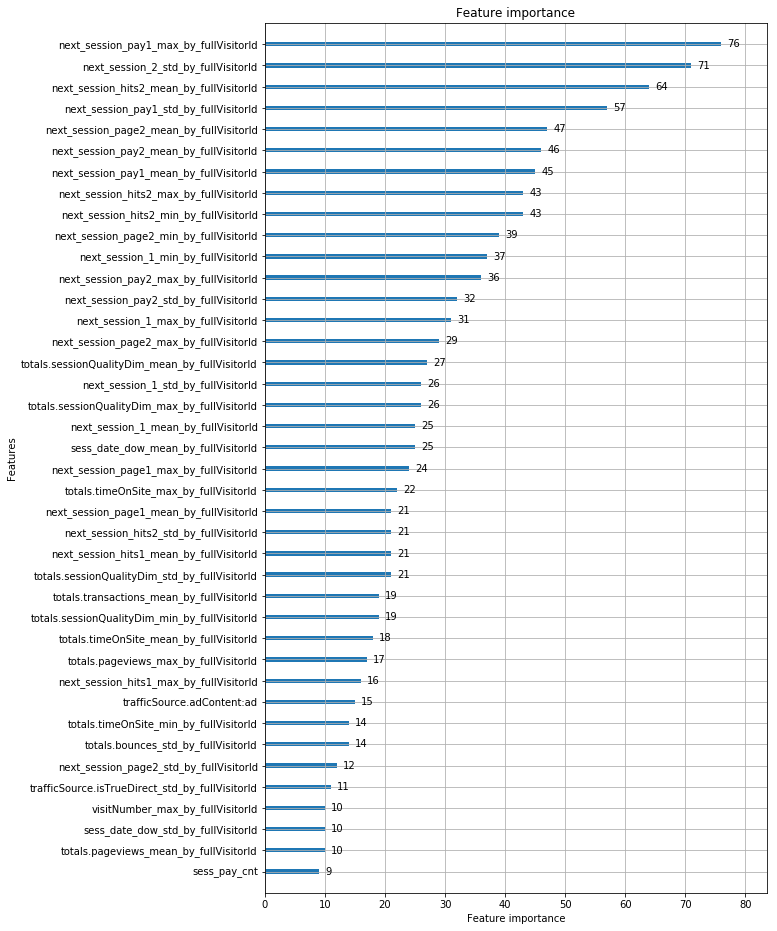

In [261]:
lgb.plot_importance(model, figsize=(9,16), max_num_features=40)

In [ ]:
for a in x_visitors:
    print(a)

In [307]:

df_


,fullVisitorId,date,next_session_pay1,next_session_pay2
226168,0000213131142648941,2017-04-28 22:41:58,-2562048,-2562048
792213,0000384434116640351,2017-10-04 08:41:36,-2562048,-2562048
1453491,0001376836098133431,2018-02-03 01:22:08,-2562048,-2562048
382239,0002290239070540853,2018-07-25 03:01:57,-2562048,-2562048
1428877,0002871498069867123,2016-08-23 14:55:08,-2562048,-2562048
219606,0003450834640354121,2016-10-18 21:20:02,-2562048,-2562048
565235,0003961110741104601,2017-05-22 04:01:22,-2562048,-2562048
379699,000435324061339869,2016-10-21 01:33:41,-2562048,-2562048
329669,0004938716430839957,2018-05-29 17:36:23,-2562048,-2562048
756849,0005735902306392332,2017-12-07 15:07:20,-2562048,-2562048


In [287]:
train_sess[train_sess['fullVisitorId']=='0001376836098133431'].iloc[:,40:50]


,sess_date_hours,sess_date_dom,next_session_1,next_session_2,next_session_hits1,next_session_hits2,next_session_page1,next_session_page2,source.country,campaign.medium
1625075,15,29,-2562048,-100,NaN,-30.0,NaN,-19.0,direct_United States,(not set)_(none)
1453727,18,2,99,-7,30.0,31.0,19.0,18.0,google_United States,(not set)_organic
1453491,1,3,6,-2562048,-31.0,NaN,-18.0,NaN,direct_United States,(not set)_(none)


### Parameter tuning

#### LightGBM tuning
##### Manual tuning (greedy search)

* Tune one parameter at a time.
* Find the best value for a parameter then move to the next one.
* Repeat the process for all the parameters we want to tune.
* Tuning with a larger learning rate 0.1.
* scale_pos_weight needs to be tuned for imbalanced dataset.

In [29]:
import copy
default_lgb_params = {}
default_lgb_params["learning_rate"] = 0.05
default_lgb_params["metric"] = 'rmse'
default_lgb_params["bagging_freq"] = 1
default_lgb_params["seed"] = 1234
default_lgb_params["objective"] = "regression"

params_lgb_space = {}
params_lgb_space['num_leaves'] = [3, 7, 15, 31, 63, 127, 255]
params_lgb_space['max_depth'] = [3 ,4 ,5 ,6 ,7 ,8, -1]
params_lgb_space['min_gain_to_split'] = [0, 0.1, 0.3, 1, 1.5, 2, 3]
params_lgb_space['feature_fraction'] = [0.1, 0.3, 0.5, 0.7, 0.9]
params_lgb_space['bagging_fraction'] = [0.2, 0.4, 0.6, 0.8, 1]
params_lgb_space['min_sum_hessian_in_leaf'] = [1, 5, 10, 30, 100]
params_lgb_space['lambda_l2'] = [0, 0.01, 0.1, 1, 10, 100]
params_lgb_space['lambda_l1'] = [0, 0.01, 0.1, 1, 10, 100]
# params_lgb_space['objective'] = ['regression', 'regression_l1', 'poisson']



greater_is_better = False

best_lgb_params = copy.copy(default_lgb_params)

for p in params_lgb_space:
    print ("\n Tuning parameter %s in %s" % (p, params_lgb_space[p]))

    params = best_lgb_params
    scores = []    
    for v in params_lgb_space[p]:
        print ('\n    %s: %s' % (p, v), end="\n")
        params[p] = v
        lgb_cv = lgb.cv(params,
                lgb.Dataset(train_x,
                            label=train_y
                            ),
                num_boost_round=100000,
                nfold=kfolds,
                folds=skf.split(train_x,train_y_dummy),
                stratified=False,
                early_stopping_rounds=50,
                verbose_eval=500)

        best_lgb_score = min(lgb_cv['rmse-mean'])
        best_lgb_iteration = len(lgb_cv['rmse-mean'])
        print (', best_score: %f, best_iteration: %d' % (best_lgb_score, best_lgb_iteration))
        scores.append([v, best_lgb_score])
    # best param value in the space
    best_param_value = sorted(scores, key=lambda x:x[1],reverse=greater_is_better)[0][0]
    best_param_score = sorted(scores, key=lambda x:x[1],reverse=greater_is_better)[0][1]
    best_lgb_params[p] = best_param_value
    print ("Best %s is %s with a score of %f" %(p, best_param_value, best_param_score))

print ('\n Best manually tuned parameters:', best_lgb_params)    


 Tuning parameter num_leaves in [3, 7, 15, 31, 63, 127, 255]

    num_leaves: 3
, best_score: 0.310915, best_iteration: 181

    num_leaves: 7
, best_score: 0.311358, best_iteration: 31

    num_leaves: 15
, best_score: 0.311893, best_iteration: 20

    num_leaves: 31
, best_score: 0.312344, best_iteration: 18

    num_leaves: 63
, best_score: 0.312682, best_iteration: 18

    num_leaves: 127
, best_score: 0.312665, best_iteration: 16

    num_leaves: 255
, best_score: 0.312551, best_iteration: 19
Best num_leaves is 3 with a score of 0.310915

 Tuning parameter max_depth in [3, 4, 5, 6, 7, 8, -1]

    max_depth: 3
, best_score: 0.310915, best_iteration: 181

    max_depth: 4
, best_score: 0.310915, best_iteration: 181

    max_depth: 5
, best_score: 0.310915, best_iteration: 181

    max_depth: 6
, best_score: 0.310915, best_iteration: 181

    max_depth: 7
, best_score: 0.310915, best_iteration: 181

    max_depth: 8
, best_score: 0.310915, best_iteration: 181

    max_depth: -1
, be

In [30]:
best_param_value = sorted(scores, key=lambda x:x[1],reverse=greater_is_better)[0][0]
best_param_score = sorted(scores, key=lambda x:x[1],reverse=greater_is_better)[0][1]
best_lgb_params[p] = best_param_value
print ("Best %s is %s with a score of %f" %(p, best_param_value, best_param_score))

print ('\n Best manually tuned parameters:', best_lgb_params)    

Best lambda_l1 is 0.01 with a score of 0.310413

 Best manually tuned parameters: {'learning_rate': 0.05, 'metric': 'rmse', 'bagging_freq': 1, 'seed': 1234, 'objective': 'regression', 'num_leaves': 3, 'max_depth': 3, 'min_gain_to_split': 1, 'feature_fraction': 0.7, 'bagging_fraction': 1, 'min_sum_hessian_in_leaf': 100, 'lambda_l2': 0.1, 'lambda_l1': 0.01}


##### Automated tuning

We will be using a package BayesianOptimization for automated tuning. Results from manual tuning can be used to further narrow the space that needs to be searched from for better performance. 

Visit https://github.com/fmfn/BayesianOptimization for more details about Bayesian Optimization.

In [31]:
from bayes_opt import BayesianOptimization


def lgb_evaluate(
    num_leaves,
    max_depth,
    min_sum_hessian_in_leaf,
    min_gain_to_split,
    feature_fraction,
    bagging_fraction,
    lambda_l2,
    lambda_l1
):
    params = dict()
    params['objective'] = 'regression'
    params['learning_rate'] = 0.05
    params['seed'] = 1234
    params['num_leaves'] = int(num_leaves)
    params['max_depth'] = int(max_depth)
    params['min_sum_hessian_in_leaf'] = int(min_sum_hessian_in_leaf)
    params['min_gain_to_split'] = min_gain_to_split
    params['feature_fraction'] = feature_fraction
    params['bagging_fraction'] = bagging_fraction
    params['bagging_freq'] = 1
    params['lambda_l2'] = lambda_l2
    params['lambda_l1'] = lambda_l1
    params["metric"] = 'rmse'

    lgb_cv = lgb.cv(params,
                    lgb.Dataset(train_x,
                                label=train_y
                                ),
                    num_boost_round=100000,
                    nfold=kfolds,
                    folds=skf.split(train_x, train_y_dummy),
                    early_stopping_rounds=50,
                    verbose_eval=500)

    best_lgb_score = min(lgb_cv['rmse-mean'])
    best_lgb_iteration = len(lgb_cv['rmse-mean'])
    print(', best_score: %f, best_iteration: %d' %
          (best_lgb_score, best_lgb_iteration))

    return -best_lgb_score


lgb_BO = BayesianOptimization(lgb_evaluate,
                              {
                                  'num_leaves': (7, 31),
                                  'max_depth': (7, 31),
                                  'min_sum_hessian_in_leaf': (0, 2),
                                  'min_gain_to_split': (0, 5),
                                  'feature_fraction': (0.3, 0.6),
                                  'bagging_fraction': (0.9, 1),
                                  'lambda_l2': (0, 1),
                                  'lambda_l1': (0, 1)
                              }
                              )

lgb_BO.maximize(init_points=5, n_iter=40)

Initialization
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   bagging_fraction |   feature_fraction |   lambda_l1 |   lambda_l2 |   max_depth |   min_gain_to_split |   min_sum_hessian_in_leaf |   num_leaves | 
, best_score: 0.310928, best_iteration: 45
    1 | 00m12s |   -0.31093 |             0.9426 |             0.4225 |      0.3329 |      0.2371 |     15.5022 |              0.8611 |                    0.5817 |       7.9155 | 
, best_score: 0.311278, best_iteration: 28
    2 | 00m10s |   -0.31128 |             0.9962 |             0.3873 |      0.3307 |      0.8237 |     25.4895 |              4.6092 |                    0.0268 |      26.9709 | 
, best_score: 0.311316, best_iteration: 26
    3 | 00m10s |   -0.31132 |             0.9439 |             0.4413 |      0.5563 |      0.8764 |     25.7917 |              4.1889 |  

C:\Users\cb7vm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.0006022]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 50, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\cb7vm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


Bayesian Optimization
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   bagging_fraction |   feature_fraction |   lambda_l1 |   lambda_l2 |   max_depth |   min_gain_to_split |   min_sum_hessian_in_leaf |   num_leaves | 
, best_score: 0.310409, best_iteration: 43
    6 | 00m25s |   -0.31041 |             0.9607 |             0.4594 |      0.7354 |      0.1788 |     29.9405 |              4.8903 |                    0.0918 |       7.0153 | 


C:\Users\cb7vm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00028543]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 47, 'nit': 3, 'warnflag': 2}
  " state: %s" % convergence_dict)


, best_score: 0.311174, best_iteration: 56
    7 | 00m25s |   -0.31117 |             0.9728 |             0.4880 |      0.0851 |      0.6776 |     30.9951 |              0.2809 |                    0.0230 |       7.7935 | 


C:\Users\cb7vm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00021729]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 51, 'nit': 7, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\cb7vm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00047345]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


, best_score: 0.311105, best_iteration: 36
    8 | 00m23s |   -0.31110 |             0.9415 |             0.4198 |      0.1039 |      0.0543 |     30.9869 |              4.7933 |                    1.6307 |      15.4700 | 
, best_score: 0.311055, best_iteration: 27
    9 | 00m25s |   -0.31105 |             0.9924 |             0.3442 |      0.9916 |      0.0042 |      7.8039 |              0.4429 |                    1.6933 |      30.5977 | 
, best_score: 0.311136, best_iteration: 22
   10 | 00m25s |   -0.31114 |             0.9510 |             0.5248 |      0.9410 |      0.1655 |     30.1863 |              0.0274 |                    0.7117 |      30.6314 | 


C:\Users\cb7vm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.0007402]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 66, 'nit': 7, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\cb7vm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-4.40700069e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\cb7vm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.00066809]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 60, 'nit': 7, 'warnflag': 2}
  " state: %s" % convergence_dict)


, best_score: 0.310854, best_iteration: 45
   11 | 00m25s |   -0.31085 |             0.9740 |             0.3136 |      0.8480 |      0.0092 |     27.4073 |              2.1627 |                    1.7198 |       7.6368 | 


C:\Users\cb7vm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00166767]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 51, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


, best_score: 0.311106, best_iteration: 19
   12 | 00m23s |   -0.31111 |             0.9399 |             0.5824 |      0.7554 |      0.0277 |     16.5131 |              4.7795 |                    1.4176 |      30.8562 | 
, best_score: 0.311213, best_iteration: 22
   13 | 00m23s |   -0.31121 |             0.9134 |             0.4633 |      0.0003 |      0.1120 |     18.4690 |              0.7290 |                    0.0939 |      30.4982 | 


C:\Users\cb7vm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00126225]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 56, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\cb7vm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.00016248]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 49, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\cb7vm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00024229]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 87, 'nit': 8, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\cb7vm\AppData\Local\Continuum\an

, best_score: 0.310426, best_iteration: 34
   14 | 00m24s |   -0.31043 |             0.9793 |             0.5991 |      0.5431 |      0.0869 |      7.6263 |              4.7460 |                    0.2273 |       9.8466 | 


C:\Users\cb7vm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-5.85374637e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 67, 'nit': 8, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\cb7vm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00378736]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 48, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


, best_score: 0.311409, best_iteration: 26
   15 | 00m26s |   -0.31141 |             0.9841 |             0.5249 |      0.9255 |      0.0716 |      7.7991 |              0.0099 |                    0.0846 |      20.7850 | 


C:\Users\cb7vm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.43057327e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 60, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\cb7vm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00035829]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 52, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\cb7vm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00016329]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 64, 'nit': 8, 'warnflag': 2}
  " state: %s" % convergence_dict)


, best_score: 0.310761, best_iteration: 35
   16 | 00m25s |   -0.31076 |             0.9955 |             0.5774 |      0.8370 |      0.0291 |     19.5713 |              4.6763 |                    0.0520 |       7.4512 | 
, best_score: 0.311418, best_iteration: 33
   17 | 00m23s |   -0.31142 |             0.9138 |             0.3813 |      0.9248 |      0.6732 |      7.6298 |              4.3953 |                    0.0909 |      30.9221 | 
, best_score: 0.310887, best_iteration: 44
   18 | 00m25s |   -0.31089 |             0.9075 |             0.4561 |      0.8220 |      0.2259 |      7.0294 |              1.2527 |                    1.7680 |       7.1149 | 
, best_score: 0.310876, best_iteration: 34
   19 | 00m24s |   -0.31088 |             0.9539 |             0.3094 |      0.0271 |      0.5202 |      7.5438 |              4.6355 |                    1.9090 |      15.1823 | 
, best_score: 0.310590, best_iteration: 46
   20 | 00m24s |   -0.31059 |             0.9356 |             0.

C:\Users\cb7vm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00405098]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\cb7vm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00549576]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


, best_score: 0.311537, best_iteration: 27
   24 | 00m24s |   -0.31154 |             0.9029 |             0.3856 |      0.2460 |      0.7580 |     30.1646 |              4.9076 |                    1.8732 |      30.6611 | 
, best_score: 0.310551, best_iteration: 34
   25 | 00m24s |   -0.31055 |             0.9970 |             0.5671 |      0.1823 |      0.9685 |      7.3530 |              3.9649 |                    1.6516 |       8.1355 | 


C:\Users\cb7vm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([3.94401141e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 59, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


, best_score: 0.311508, best_iteration: 26
   26 | 00m26s |   -0.31151 |             0.9782 |             0.4228 |      0.7337 |      0.9186 |     19.2167 |              0.4341 |                    1.8268 |      30.8915 | 


C:\Users\cb7vm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([6.997322e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 51, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


, best_score: 0.310859, best_iteration: 29
   27 | 00m24s |   -0.31086 |             0.9201 |             0.5414 |      0.8059 |      0.0488 |      7.6334 |              4.7368 |                    1.9542 |      10.9088 | 


C:\Users\cb7vm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.00051601]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


, best_score: 0.311562, best_iteration: 22
   28 | 00m24s |   -0.31156 |             0.9824 |             0.5718 |      0.2694 |      0.0952 |      8.4492 |              4.9781 |                    1.9763 |      30.9413 | 


C:\Users\cb7vm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.00011794]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)


, best_score: 0.311001, best_iteration: 39
   29 | 00m25s |   -0.31100 |             0.9134 |             0.3569 |      0.0689 |      0.9103 |      7.2052 |              0.3951 |                    0.3824 |      11.4648 | 


C:\Users\cb7vm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00021232]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 56, 'nit': 7, 'warnflag': 2}
  " state: %s" % convergence_dict)


, best_score: 0.310814, best_iteration: 28
   30 | 00m25s |   -0.31081 |             0.9990 |             0.5682 |      0.1625 |      0.6964 |     16.0024 |              4.5425 |                    0.4363 |      15.0121 | 


C:\Users\cb7vm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([3.51011913e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


, best_score: 0.310797, best_iteration: 29
   31 | 00m25s |   -0.31080 |             0.9809 |             0.5969 |      0.1653 |      0.6279 |      9.1410 |              4.1247 |                    0.0324 |      12.8069 | 


C:\Users\cb7vm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([5.28311357e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\cb7vm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00504788]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


, best_score: 0.310910, best_iteration: 29
   32 | 00m26s |   -0.31091 |             0.9845 |             0.5848 |      0.1471 |      0.0350 |     23.0004 |              0.3798 |                    1.9282 |      14.7520 | 


C:\Users\cb7vm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00674298]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 62, 'nit': 7, 'warnflag': 2}
  " state: %s" % convergence_dict)


, best_score: 0.310596, best_iteration: 39
   33 | 00m26s |   -0.31060 |             0.9769 |             0.4905 |      0.2337 |      0.4995 |     27.2753 |              4.7467 |                    0.1418 |       8.1302 | 
, best_score: 0.310844, best_iteration: 28
   34 | 00m25s |   -0.31084 |             0.9436 |             0.5787 |      0.7085 |      0.2310 |     22.8933 |              4.8041 |                    0.1172 |      14.8609 | 
, best_score: 0.310730, best_iteration: 42
   35 | 00m25s |   -0.31073 |             0.9849 |             0.3079 |      0.9759 |      0.4536 |      7.5251 |              2.7691 |                    0.1865 |       8.1515 | 


C:\Users\cb7vm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([4.42694873e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)


, best_score: 0.310805, best_iteration: 31
   36 | 00m28s |   -0.31080 |             0.9819 |             0.5016 |      0.8955 |      0.3608 |      7.0549 |              3.7063 |                    0.4744 |       9.7815 | 


C:\Users\cb7vm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00024753]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 66, 'nit': 8, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\cb7vm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00944975]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 74, 'nit': 7, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\cb7vm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00962618]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 65, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


, best_score: 0.311085, best_iteration: 50
   37 | 00m29s |   -0.31108 |             0.9790 |             0.4707 |      0.7741 |      0.2694 |     24.8324 |              0.0354 |                    0.0254 |       7.3041 | 


C:\Users\cb7vm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.00048034]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 50, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\cb7vm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00869836]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 58, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)


, best_score: 0.310771, best_iteration: 53
   38 | 00m30s |   -0.31077 |             0.9694 |             0.4443 |      0.9903 |      0.8284 |     10.8616 |              0.4628 |                    1.9732 |       7.1320 | 


C:\Users\cb7vm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00042925]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\cb7vm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.640954e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


, best_score: 0.311015, best_iteration: 40
   39 | 00m28s |   -0.31101 |             0.9871 |             0.3389 |      0.2055 |      0.0802 |     17.3782 |              4.4394 |                    1.4095 |      10.4325 | 


C:\Users\cb7vm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.0004727]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\cb7vm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.91568397e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 74, 'nit': 7, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\cb7vm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00052417]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 58, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\cb7vm\AppData\Local\Continuu

, best_score: 0.310630, best_iteration: 51
   40 | 00m30s |   -0.31063 |             0.9994 |             0.3373 |      0.5458 |      0.6692 |      7.1067 |              0.0136 |                    1.9919 |       7.4071 | 


C:\Users\cb7vm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.006342]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 7, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\cb7vm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.00041853]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 7, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\cb7vm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.937094e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 71, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)


, best_score: 0.311000, best_iteration: 34
   41 | 00m26s |   -0.31100 |             0.9379 |             0.3833 |      0.5067 |      0.0036 |     13.9561 |              4.8771 |                    0.6041 |      23.8612 | 


C:\Users\cb7vm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([3.01441178e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 61, 'nit': 8, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\cb7vm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.0046947]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 78, 'nit': 7, 'warnflag': 2}
  " state: %s" % convergence_dict)


, best_score: 0.311162, best_iteration: 29
   42 | 00m28s |   -0.31116 |             0.9808 |             0.5706 |      0.3163 |      0.0819 |      8.4249 |              0.1402 |                    0.6009 |       9.0837 | 


C:\Users\cb7vm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.0062916]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 63, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\cb7vm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-4.18790441e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 89, 'nit': 10, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\cb7vm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00032513]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 66, 'nit': 7, 'warnflag': 2}
  " state: %s" % convergence_dict)


, best_score: 0.311185, best_iteration: 39
   43 | 00m30s |   -0.31118 |             0.9230 |             0.3663 |      0.0011 |      0.0906 |     27.7683 |              0.1306 |                    1.9183 |      26.2029 | 


C:\Users\cb7vm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.02547569]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 51, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\cb7vm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.0130975]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 69, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\cb7vm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.0009433]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 65, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\cb7vm\AppData\Local\Continuum\ana

, best_score: 0.311016, best_iteration: 23
   44 | 00m29s |   -0.31102 |             0.9557 |             0.4453 |      0.0525 |      0.2024 |      7.0153 |              0.4051 |                    0.3634 |      30.2483 | 


C:\Users\cb7vm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00578325]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 49, 'nit': 3, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\cb7vm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.01597998]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 76, 'nit': 8, 'warnflag': 2}
  " state: %s" % convergence_dict)


, best_score: 0.310878, best_iteration: 36
   45 | 00m28s |   -0.31088 |             0.9134 |             0.5280 |      0.8838 |      0.0198 |     29.6253 |              3.6698 |                    0.0110 |      10.0970 | 


C:\Users\cb7vm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00510502]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 52, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\cb7vm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00038344]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 57, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\cb7vm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.01036175]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 52, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


##### Display automated tuning results

In [32]:
# gc.collect()

lgb_BO_scores = pd.DataFrame(lgb_BO.res['all']['params'])
lgb_BO_scores['score'] = pd.DataFrame(lgb_BO.res['all']['values'])
lgb_BO_scores = lgb_BO_scores.sort_values(by='score',ascending=False)

lgb_BO_scores.to_csv("../python/tuned_lgb_parameters.csv", index=False)
lgb_BO_scores.head()

,bagging_fraction,feature_fraction,lambda_l1,lambda_l2,max_depth,min_gain_to_split,min_sum_hessian_in_leaf,num_leaves,score
0,0.960732,0.459447,0.735415,0.178765,29.940490,4.890276,0.091817,7.015328,-0.310409
8,0.979340,0.599100,0.543076,0.086898,7.626286,4.745991,0.227268,9.846632,-0.310426
19,0.996953,0.567112,0.182347,0.968530,7.353044,3.964879,1.651617,8.135507,-0.310551
14,0.935609,0.317596,0.885520,0.554937,7.348190,4.696261,0.118799,7.659261,-0.310590
27,0.976859,0.490475,0.233653,0.499533,27.275256,4.746707,0.141809,8.130215,-0.310596


##### Retrain the model with smaller learning rate 

In [33]:
params = lgb_BO_scores.iloc[0].to_dict()
best_auto_lgb_params = dict()
best_auto_lgb_params['objective'] = 'regression'
best_auto_lgb_params["metric"] = 'rmse'
best_auto_lgb_params['learning_rate'] = 0.05 # Smaller learning rate
best_auto_lgb_params['num_leaves'] = int(params['num_leaves'])    
best_auto_lgb_params['max_depth'] = int(params['max_depth'])    
best_auto_lgb_params['min_sum_hessian_in_leaf'] = int(params['min_sum_hessian_in_leaf'])
best_auto_lgb_params['min_gain_to_split'] = params['min_gain_to_split']     
best_auto_lgb_params['feature_fraction'] = params['feature_fraction']
best_auto_lgb_params['bagging_fraction'] = params['bagging_fraction']
best_auto_lgb_params['bagging_freq'] = 1
best_auto_lgb_params['lambda_l2'] = params['lambda_l2']
best_auto_lgb_params['lambda_l1'] = params['lambda_l1']
best_auto_lgb_params['seed'] = 1234


print (best_auto_lgb_params)


lgb_cv = lgb.cv(best_auto_lgb_params,
            lgb.Dataset(train_x,
                        label=train_y
                        ),
            num_boost_round=100000,
            nfold=kfolds,
            folds=skf.split(train_x,train_y_dummy),
            early_stopping_rounds=50,
            verbose_eval=500)

best_lgb_score = min(lgb_cv['rmse-mean'])
best_lgb_iteration = len(lgb_cv['rmse-mean'])
print (', best_score: %f, best_iteration: %d' % (best_lgb_score, best_lgb_iteration))

{'objective': 'regression', 'metric': 'rmse', 'learning_rate': 0.05, 'num_leaves': 7, 'max_depth': 29, 'min_sum_hessian_in_leaf': 0, 'min_gain_to_split': 4.890276095799749, 'feature_fraction': 0.4594465361933296, 'bagging_fraction': 0.9607324493788795, 'bagging_freq': 1, 'lambda_l2': 0.17876481733810545, 'lambda_l1': 0.7354145488251757, 'seed': 1234}
, best_score: 0.310409, best_iteration: 43


### Stacking

#### Define stacking functions

In [34]:
from sklearn.model_selection import StratifiedKFold, KFold 
import copy

def lgb_rgr_stack(rgr_params, train_x, train_y, test_x, kfolds, early_stopping_rounds=0, train_y_dummy=None):

    skf = KFold(n_splits=kfolds,random_state=1234)
    skf_ids = list(skf.split(train_y_dummy))


    train_blend_x = np.zeros((train_x.shape[0], len(rgr_params)))
    test_blend_x = np.zeros((test_x.shape[0], len(rgr_params)))
    blend_scores = np.zeros ((kfolds,len(rgr_params)))

    print  ("Start stacking.")
    for j, params in enumerate(rgr_params):
        print ("Stacking model",j+1, params)
        test_blend_x_j = np.zeros((test_x.shape[0]))
        for i, (train_ids, val_ids) in enumerate(skf_ids):
            start = time.time()
            print ("Model %d fold %d" %(j+1,i+1))
            train_x_fold = train_x[train_ids]
            train_y_fold = train_y[train_ids]
            val_x_fold = train_x[val_ids]
            val_y_fold = train_y[val_ids]
            print (i, params)
            
            
            if early_stopping_rounds==0:
                num_boost_round = copy.deepcopy(params['num_boost_round'])
                model = lgb.train(params,
                                    lgb.Dataset(train_x_fold, 
                                                train_y_fold
                                               ),
                                  num_boost_round=num_boost_round,
                                  verbose_eval=500
                                )
                val_y_predict_fold = model.predict(val_x_fold)
                score = np.sqrt(mean_squared_error(val_y_fold,val_y_predict_fold))
                print ("Score for Model %d fold %d: %f " % (j+1,i+1,score))
                blend_scores[i,j]=score
                train_blend_x[val_ids, j] = val_y_predict_fold
                test_blend_x_j = test_blend_x_j + model.predict(test_x)
                print ("Model %d fold %d finished in %d seconds." % (j+1,i+1, time.time()-start))
            else:
                model = lgb.train(params,
                                    lgb.Dataset(train_x_fold, 
                                                train_y_fold
                                               ),
                                  valid_sets=[lgb.Dataset(val_x_fold, 
                                                val_y_fold
                                                         )],
                                  valid_names=['valid'],
                                  num_boost_round=10000000,
                                  early_stopping_rounds = early_stopping_rounds,
                                  verbose_eval=500
                                )
                best_iteration = model.best_iteration
                print(model.best_score['valid']['rmse'])
                val_y_predict_fold = model.predict(val_x_fold, num_iteration=best_iteration)
                score = np.sqrt(mean_squared_error(val_y_fold,val_y_predict_fold))
                print ("Score for Model %d fold %d: %f " % (j+1,i+1,score))
                blend_scores[i,j]=score
                train_blend_x[val_ids, j] = val_y_predict_fold
                test_blend_x_j = test_blend_x_j + model.predict(test_x, num_iteration=best_iteration)
                print ("Model %d fold %d finished in %d seconds." % (j+1,i+1, time.time()-start))                
                
        test_blend_x[:,j] = test_blend_x_j/kfolds
        print ("Score for model %d is %f" % (j+1,np.mean(blend_scores[:,j])))
    return train_blend_x, test_blend_x, blend_scores    

#### Level 1: top 5 LightGBM models

We will generate level 1 predictions using parameters of the top 5 models from automated tuning.

In [35]:
lgb_params = []
## Top 5 auto-tuned parameters
for i in range(5):
    params=dict()
    params['num_leaves'] = int(lgb_BO_scores['num_leaves'][i])
    params['max_depth'] = int(lgb_BO_scores['max_depth'][i])
    params['min_sum_hessian_in_leaf'] = int(lgb_BO_scores['min_sum_hessian_in_leaf'][i])
    params['min_gain_to_split'] = lgb_BO_scores['min_gain_to_split'][i]
    params['feature_fraction'] = lgb_BO_scores['feature_fraction'][i]
    params['bagging_fraction'] = lgb_BO_scores['bagging_fraction'][i]
    params['bagging_freq'] = 1
    params['lambda_l2'] = lgb_BO_scores['lambda_l2'][i]
    params['lambda_l1'] = int(lgb_BO_scores['lambda_l1'][i])
    params['objective'] = 'regression'
    params['learning_rate'] = 0.05
    params['num_boost_round']=best_lgb_iteration
    params['seed'] = 1234
    params["metric"] = 'rmse'
    lgb_params.append(params)

## Best manual-tuned parameters
lgb_params.append(best_lgb_params)    
print (lgb_params)

[{'num_leaves': 7, 'max_depth': 29, 'min_sum_hessian_in_leaf': 0, 'min_gain_to_split': 4.890276095799749, 'feature_fraction': 0.4594465361933296, 'bagging_fraction': 0.9607324493788795, 'bagging_freq': 1, 'lambda_l2': 0.17876481733810545, 'lambda_l1': 0, 'objective': 'regression', 'learning_rate': 0.05, 'num_boost_round': 43, 'seed': 1234, 'metric': 'rmse'}, {'num_leaves': 7, 'max_depth': 30, 'min_sum_hessian_in_leaf': 0, 'min_gain_to_split': 0.28088507463544743, 'feature_fraction': 0.4880215181236464, 'bagging_fraction': 0.9728243993960635, 'bagging_freq': 1, 'lambda_l2': 0.6776167748526225, 'lambda_l1': 0, 'objective': 'regression', 'learning_rate': 0.05, 'num_boost_round': 43, 'seed': 1234, 'metric': 'rmse'}, {'num_leaves': 15, 'max_depth': 30, 'min_sum_hessian_in_leaf': 1, 'min_gain_to_split': 4.793252741174074, 'feature_fraction': 0.41975540941038303, 'bagging_fraction': 0.9414728814013633, 'bagging_freq': 1, 'lambda_l2': 0.054317568212704614, 'lambda_l1': 0, 'objective': 'regress

In [36]:
train_blend_x_lgb, test_blend_x_lgb, blend_scores_lgb = \
        lgb_rgr_stack(lgb_params, train_x, train_y, test_x, 5, early_stopping_rounds=50, train_y_dummy=train_y_dummy)


Start stacking.
Stacking model 1 {'num_leaves': 7, 'max_depth': 29, 'min_sum_hessian_in_leaf': 0, 'min_gain_to_split': 4.890276095799749, 'feature_fraction': 0.4594465361933296, 'bagging_fraction': 0.9607324493788795, 'bagging_freq': 1, 'lambda_l2': 0.17876481733810545, 'lambda_l1': 0, 'objective': 'regression', 'learning_rate': 0.05, 'num_boost_round': 43, 'seed': 1234, 'metric': 'rmse'}
Model 1 fold 1
0 {'num_leaves': 7, 'max_depth': 29, 'min_sum_hessian_in_leaf': 0, 'min_gain_to_split': 4.890276095799749, 'feature_fraction': 0.4594465361933296, 'bagging_fraction': 0.9607324493788795, 'bagging_freq': 1, 'lambda_l2': 0.17876481733810545, 'lambda_l1': 0, 'objective': 'regression', 'learning_rate': 0.05, 'num_boost_round': 43, 'seed': 1234, 'metric': 'rmse'}


C:\Users\cb7vm\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:116: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[43]	valid's rmse: 0.287952
0.2879521714946926
Score for Model 1 fold 1: 0.287952 
Model 1 fold 1 finished in 3 seconds.
Model 1 fold 2
1 {'num_leaves': 7, 'max_depth': 29, 'min_sum_hessian_in_leaf': 0, 'min_gain_to_split': 4.890276095799749, 'feature_fraction': 0.4594465361933296, 'bagging_fraction': 0.9607324493788795, 'bagging_freq': 1, 'lambda_l2': 0.17876481733810545, 'lambda_l1': 0, 'objective': 'regression', 'learning_rate': 0.05, 'num_boost_round': 43, 'seed': 1234, 'metric': 'rmse'}
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[42]	valid's rmse: 0.34194
0.34193955040125734
Score for Model 1 fold 2: 0.341940 
Model 1 fold 2 finished in 3 seconds.
Model 1 fold 3
2 {'num_leaves': 7, 'max_depth': 29, 'min_sum_hessian_in_leaf': 0, 'min_gain_to_split': 4.890276095799749, 'feature_fraction': 0.4594465361933296, 

3 {'num_leaves': 15, 'max_depth': 30, 'min_sum_hessian_in_leaf': 1, 'min_gain_to_split': 4.793252741174074, 'feature_fraction': 0.41975540941038303, 'bagging_fraction': 0.9414728814013633, 'bagging_freq': 1, 'lambda_l2': 0.054317568212704614, 'lambda_l1': 0, 'objective': 'regression', 'learning_rate': 0.05, 'num_boost_round': 43, 'seed': 1234, 'metric': 'rmse'}
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[13]	valid's rmse: 0.320127
0.32012739520925704
Score for Model 3 fold 4: 0.320127 
Model 3 fold 4 finished in 3 seconds.
Model 3 fold 5
4 {'num_leaves': 15, 'max_depth': 30, 'min_sum_hessian_in_leaf': 1, 'min_gain_to_split': 4.793252741174074, 'feature_fraction': 0.41975540941038303, 'bagging_fraction': 0.9414728814013633, 'bagging_freq': 1, 'lambda_l2': 0.054317568212704614, 'lambda_l1': 0, 'objective': 'regression', 'learning_rate': 0.05, 'num_boost_round': 43, 'seed': 1234, 'metric': 'rmse'}
Training until validation

0 {'learning_rate': 0.05, 'metric': 'rmse', 'bagging_freq': 1, 'seed': 1234, 'objective': 'regression', 'num_leaves': 3, 'max_depth': 3, 'min_gain_to_split': 1, 'feature_fraction': 0.7, 'bagging_fraction': 1, 'min_sum_hessian_in_leaf': 100, 'lambda_l2': 0.1, 'lambda_l1': 0.01}
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[132]	valid's rmse: 0.287548
0.2875478019650146
Score for Model 6 fold 1: 0.287548 
Model 6 fold 1 finished in 5 seconds.
Model 6 fold 2
1 {'learning_rate': 0.05, 'metric': 'rmse', 'bagging_freq': 1, 'seed': 1234, 'objective': 'regression', 'num_leaves': 3, 'max_depth': 3, 'min_gain_to_split': 1, 'feature_fraction': 0.7, 'bagging_fraction': 1, 'min_sum_hessian_in_leaf': 100, 'lambda_l2': 0.1, 'lambda_l1': 0.01}
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[138]	valid's rmse: 0.341699
0.341698894951824
Score for Model 6 fold 2: 0.341699 
Model 6 fold 2 finished in 5 s

In [37]:
np.sqrt(mean_squared_error(train_y,train_blend_x_lgb.mean(axis=1)))
# 0.3182835364470343

0.3104139394569992

In [38]:
[np.sqrt(mean_squared_error(train_y,train_blend_x_lgb[:,n])) for n in range(6)]

[0.31095568380321276,
 0.3109263751881964,
 0.3110045420862678,
 0.31049638085459175,
 0.31138301920974054,
 0.31081858782328925]

#### Level 2 stacking

We will be using the predictions (Level 1 features) to train another model as Level 2 which will then be used to make the actual predictions.

In [39]:
# Stacke level 1 features
train_blend_x = train_blend_x_lgb
test_blend_x = test_blend_x_lgb

In [40]:
from sklearn.metrics import make_scorer
def my_rmse(y_true, y_preds):
    return np.sqrt(mean_squared_error(y_true, y_preds))

my_rmse_score = make_scorer(my_rmse, greater_is_better=False)

In [41]:
from sklearn.linear_model import Ridge,ElasticNet, SGDRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
def search_model(train_x, train_y, est, param_grid, n_jobs, cv, refit=False):
##Grid Search for the best model
    model = GridSearchCV(estimator  = est,
                                     param_grid = param_grid,
                                     scoring    = my_rmse_score,
                                     verbose    = 10,
                                     n_jobs  = n_jobs,
                                     iid        = True,
                                     refit    = refit,
                                     cv      = cv)
    # Fit Grid Search Model
    model.fit(train_x, train_y)
    print("Best score: %0.3f" % model.best_score_)
    print("Best parameters set:", model.best_params_)
    print("Scores:", model.grid_scores_)
    return model

In [42]:
param_grid = {
              "alpha":[0.001,0.01,0.1,1,10,30,100]
              }
model = search_model(train_blend_x
                                         , train_y
                                         , Ridge()
                                         , param_grid
                                         , n_jobs=1
                                         , cv=skf.split(train_x, train_y_dummy)
                                         , refit=True)   

print ("best alpha:", model.best_params_)


preds_ridge = np.expm1(model.predict(test_blend_x))

sub = pd.DataFrame()
sub['fullVisitorId'] = test_ids
sub['revenue'] = preds_ridge
sub.to_csv('../output/sub_stacking_ridge.csv', index=False)


Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV] alpha=0.001 .....................................................
[CV] .......... alpha=0.001, score=-0.31343913159595144, total=   0.0s
[CV] alpha=0.001 .....................................................
[CV] ............ alpha=0.001, score=-0.302767903378481, total=   0.0s
[CV] alpha=0.001 .....................................................
[CV] ........... alpha=0.001, score=-0.3125921766771382, total=   0.0s
[CV] alpha=0.001 .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s


[CV] .......... alpha=0.001, score=-0.31407253106667804, total=   0.0s
[CV] alpha=0.001 .....................................................
[CV] ............ alpha=0.001, score=-0.309437815377468, total=   0.0s
[CV] alpha=0.01 ......................................................
[CV] ............ alpha=0.01, score=-0.3134390677173769, total=   0.0s
[CV] alpha=0.01 ......................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.4s remaining:    0.0s


[CV] ............ alpha=0.01, score=-0.3027678775910538, total=   0.0s
[CV] alpha=0.01 ......................................................
[CV] ............ alpha=0.01, score=-0.3125921527729613, total=   0.0s
[CV] alpha=0.01 ......................................................
[CV] ........... alpha=0.01, score=-0.31407247815051087, total=   0.0s
[CV] alpha=0.01 ......................................................
[CV] ............ alpha=0.01, score=-0.3094375943303658, total=   0.0s
[CV] alpha=0.1 .......................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.5s remaining:    0.0s


[CV] ............. alpha=0.1, score=-0.3134384289958777, total=   0.0s
[CV] alpha=0.1 .......................................................
[CV] ............. alpha=0.1, score=-0.3027676211631676, total=   0.0s
[CV] alpha=0.1 .......................................................
[CV] ............ alpha=0.1, score=-0.31259191416532234, total=   0.0s
[CV] alpha=0.1 .......................................................
[CV] ............. alpha=0.1, score=-0.3140719516683518, total=   0.0s
[CV] alpha=0.1 .......................................................
[CV] ............ alpha=0.1, score=-0.30943539252694935, total=   0.0s
[CV] alpha=1 .........................................................
[CV] .............. alpha=1, score=-0.31343205020018705, total=   0.0s
[CV] alpha=1 .........................................................
[CV] ............... alpha=1, score=-0.3027651955725166, total=   0.0s
[CV] alpha=1 .........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    2.2s finished
C:\Users\cb7vm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


### Level 2 stacking II 

Stacking can also be done by with both level 1 predictions and original features.

In [43]:
train_blend_x = sparse.hstack([train_x, train_blend_x_lgb]).tocsr()
test_blend_x = sparse.hstack([test_x, test_blend_x_lgb]).tocsr()

print (train_blend_x.shape, train_blend_x.shape)

(361469, 4307) (361469, 4307)


In [44]:
lgb_params = {'learning_rate': 0.05, 'metric': 'rmse',
              'bagging_freq': 1, 'seed': 1234, 'objective': 'regression',
              'num_leaves': 7, 'verbose': 1,
              'max_depth': 5, 'min_gain_to_split': 0,
              'feature_fraction': 0.1,
              'bagging_fraction': 0.9,
              'min_sum_hessian_in_leaf': 1,
              'lambda_l2': 0, 'lambda_l1': 0
              }


lgb_cv = lgb.cv(lgb_params,
                lgb.Dataset(train_blend_x,
                            label=train_y
                            ),
                num_boost_round=100000,
                nfold=kfolds,
                folds=skf.split(train_blend_x, train_y_dummy),
                early_stopping_rounds=50,
                verbose_eval=500)

best_lgb_score = min(lgb_cv['rmse-mean'])
best_lgb_iteration = len(lgb_cv['rmse-mean'])
print(', best_score: %f, best_iteration: %d' %
      (best_lgb_score, best_lgb_iteration))


# {'learning_rate': 0.05, 'metric': 'rmse', 'bagging_freq': 1, 'seed': 1234, 'objective': 'regression', 'num_leaves': 15, 'verbose': 1, 'max_depth': -1, 'min_gain_to_split': 0, 'feature_fraction': 0.5, 'bagging_fraction': 1, 'min_sum_hessian_in_leaf': 1, 'lambda_l2': 0, 'lambda_l1': 0}
# , best_score: 0.314956, best_iteration: 31

, best_score: 0.310908, best_iteration: 48


In [45]:
model = lgb.train(lgb_params,
            lgb.Dataset(train_blend_x,
                        label=train_y
                        ),
            num_boost_round=best_lgb_iteration)
preds_lgb = np.expm1(model.predict(test_blend_x))

sub = pd.DataFrame()
sub['fullVisitorId'] = test_ids
sub['revenue'] = preds_lgb
sub.to_csv('../output/sub_stacking_lgb.csv', index=False)

#### Averaging level 2 predictions

We can also create a quick ensemble by averaging level 2 predictions:

In [48]:
preds_l2 = preds_ridge*0.5 + preds_lgb*0.5
sub = pd.DataFrame()
sub['fullVisitorId'] = test_ids
sub['PredictedLogRevenue'] = preds_l2
sub.to_csv('../output/v2_sub_stacking_l2.csv', index=False)
